#Pattern identification tool

Below are two modules that are useful together as a tool for the identification of graphical patterns, given from a module trained in the recognition of the main patterns of the financial market. On the one hand, there is a module that counts the number of patterns of a market in a specific period of time, in order to know the presence of a certain type of graphical pattern in a market. On the other hand, there is a module capable of recognizing in real time the presence of the requested pattern, for the latter makes use of an API.

---

In [ ]:
#@title Dependencies
%%capture

import pandas as pd;
from tensorflow import keras;
import numpy as np;
import matplotlib.pyplot as plt;
from pprint import PrettyPrinter;

#Library for visualization of data on candlestick charts
!pip install mpl_finance;
import mpl_finance as mpf;

In [ ]:
#Connection where the data and the trained model are located.
#@title Path of model

from google.colab import drive
drive.mount('/content/drive')
model_path = '/content/drive/MyDrive/Tesis de grado/CNN_model_pattern.h5' #@param {type: "string"}
model = keras.models.load_model(model_path)

Mounted at /content/drive


In [ ]:
#@title Useful functions

window = 28
# GAF function, converts a time series to a Gramian matrix.
def serie_tiempo_gaf(serie,valueMax,valueMin):
  if valueMax == valueMin:
      mGaf = np.zeros((len(serie), len(serie)))
  else:
      serieNorm = np.array((serie-valueMin) / (valueMax-valueMin))
      serieNormArc = np.arccos(serieNorm)
      mGaf = np.zeros((len(serieNorm), len(serieNorm)))
      for f in range(len(serieNorm)):
          for c in range(len(serieNorm)):
              mGaf[f, c] = np.cos(serieNormArc[f] + serieNormArc[c])
  return mGaf


# Function that receives a set of patterns with a predefined structure and that are converted through the GAF method.
def create_gaf(serie_pattern):
  data = serie_pattern.copy()
  gaf = np.zeros((data.shape[0], data.shape[1], data.shape[1], data.shape[2]))
  for i in range(data.shape[0]):
      for c in range(data.shape[2]):
          oneCat = data[i, :, c]
          maxV = np.amax(oneCat)
          minV = np.amin(oneCat)
          result = serie_tiempo_gaf(oneCat, maxV, minV)
          gaf[i, :, :, c] = result
  return gaf


# Function that returns a structured data series with the candlestick data for each pattern.
def create_serie(df_pattern, max='max', min='min', open='open', close='close'):
  total = int(df_pattern.shape[0] - window )
  if total == 0 and df_pattern.shape[0] == window:
    total = 1
  serie = np.zeros((total, window, 4))
  for N in range(total):
    df = df_pattern.loc[(df_pattern.index >= (N)) & (df_pattern.index < (N + window))]
    serie[N, :, 0] = df[open]
    serie[N, :, 1] = df[max]
    serie[N, :, 2] = df[min]
    serie[N, :, 3] = df[close]
  return serie

# function to view candlestick chart of labeled pattern
def pattern_show_image(signal, target, max='max', min='min', open='open', close='close'):           
  fontsize=12
  plt.rcParams['xtick.labelsize'] = fontsize  
  plt.rcParams['ytick.labelsize'] = fontsize 
  plt.rcParams['axes.titlesize'] = fontsize           
  fig = plt.figure(figsize=(8, 8))
  ax = plt.subplot2grid((1, 1), (0, 0))           
  ax.set_xticks(range(10))
  ax.set_xticklabels(target.index)                     
  arr = np.c_[range(target.shape[0]), target[[open, max, min, close]].values]
  mpf.candlestick_ohlc(ax, arr, width=0.5, alpha=1, colordown='#ff1717', colorup='#53c156')          
  locs, labels = plt.xticks() 
  plt.setp(labels , rotation = 45)
  plt.grid()
  ax.legend(loc = 'best', prop = {'size': fontsize})
  title_name = signal
  ax.set_title(title_name)
  fig.subplots_adjust(bottom = 0.25)       
  name = signal
  plt.axis('off')
  plt.show()



---

# Search by market
Module to run the model trained on a data set of a specific market, in order to count the number of certain patterns that have more presence in a specific market.

Number of records:  210892
Analyzing data...
5550/5550 [==============================] - 19s 2ms/step
Number of head and shoulder patterns identified:  3044
Number of double-top patterns identified:  4420
Elapsed time: 1110.9003853798 seconds.


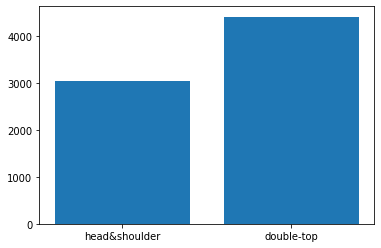

In [ ]:
#@title Get information of data
from time import time
start_time = time()

path_data = '/content/drive/MyDrive/Tesis de grado/datos/Datos sin procesar/QuantDataManager/last year/otros mercados/indices/LastYear-EUSIDXEUR-M1.csv' #@param {type: "string"}

# Test data
h = pd.read_csv(path_data,
                header=0, names=["Date","Time","Open","High","Low","Close","Volume"])

copy = h.iloc[0:177600].copy() 
print("Number of records: ",h.index.stop)

print("Analyzing data...")
copy = copy.reset_index()
r= None
prediction = None
r = create_gaf(create_serie(copy, 'High', 'Low', 'Open','Close'))


# Use of the trained model to evaluate the data
prediction = model.predict(r)

# Detection accuracy 
accuracy_data = 0.995

# Configuration of the pattern to be identified
cant_sh = 0
cant_dt = 0
pattern_to_detect = 's&h'
types_pattern = {
    's&h': 0,
    'dt': 1
}
position_serie = types_pattern[pattern_to_detect]

aux = 0
for item in prediction:
  if item[0] > accuracy_data:
      cant_sh = cant_sh + 1
  if item[1] > accuracy_data:
      cant_dt = cant_dt + 1
  #if item[position_serie] > accuracy_data:
    #aux = aux + 1 

# Number of patterns found in the data set
print("Number of head and shoulder patterns identified: ",cant_sh)
print("Number of double-top patterns identified: ",cant_dt)

elapsed_time = time() - start_time
print("Elapsed time: %0.10f seconds." % elapsed_time)

x = ['head&shoulder', 'double-top']
y = [cant_sh, cant_dt]

plt.bar(x, y)
plt.show()


---

#Real-time pattern identification
Module to identify a certain pattern chosen within a market. For this it communicates through an API with the data of a particular market and every minute with the new information about the formation of a new Japanese candlestick is analyzed for the possible presence of a pattern.
Here we make use of the marketdata.trademade website, in order to obtain minute by minute the values of the new Japanese candle that has been formed in the market, for this is registered on the web to obtain an API key access and from this begins to make calls to continuously obtain the current state of the market from the current date indicated.
In case of having an alternative data source it is only necessary to change the url associated with the new platform and configure the new api key of this one.
In its specific use you can observe how minute by minute the possible identification of graphic patterns is analyzed. In case of being identified, the related information is printed. 


In [ ]:
#@title Connection with exchange 'marketdata.tradermade'
from tensorflow.python.ops.array_ops import batch_matrix_set_diag_eager_fallback
from time import time, sleep
from datetime import datetime
from datetime import timedelta
import requests


# Configuration variables on the API 
currency = 'EURUSD' #@param {type:string};
api_key = "******************" #@param {type:string};
time_str = '20-02-2023 11:23' #@param {type:string};
date_format_str = '%d-%m-%Y %H:%M'

given_time = datetime.strptime(time_str, date_format_str)
accuracy_pattern = 0.95
pattern_size = 28
aux_windows_pattern = []

# Type of pattern to be identified
pattern_to_detect = 's&h'
types_pattern = {
    's&h': 0,
    'dt': 1
}
position_serie = types_pattern[pattern_to_detect]

cant_sh = 0
cant_dt = 0

# Market data are processed in this function, provided that there is a previous buffer of data to contain a pattern.
# When the information is processed, the market data is transformed by GAF, then it goes through the trained model.
# If a pattern is identified above the agreed upon presicion, it is reported and displayed on the screen.
def build_data_predict(data):
  if len(aux_windows_pattern) == pattern_size:
    df = pd.DataFrame(aux_windows_pattern)
    prediction = model.predict(create_gaf(create_serie(df,'high','low','open','close')))
    if prediction[0][0] > accuracy_pattern or prediction[0][1] > accuracy_pattern:
      print('Prediction of ',prediction[0][position_serie])
      pattern_show_image('signal', df, 'high','low','open','close')
      global cant_sh
      global cant_dt
      if prediction[0][0] > accuracy_pattern:
        cant_sh = cant_sh + 1
        print("New 'head and shoulders' chart pattern detected")
      else:
        cant_dt = cant_dt + 1
        print("New 'double-top' chart pattern detected")
    else:
      print('Pattern not detect')
    aux_windows_pattern.append(data)
    aux_windows_pattern.pop(0)
  else:
    aux_windows_pattern.append(data)


#seconds_array = []
print("Starting to analyze data ...")
# Time loop, advancing one minute at a time and calling the API and entering the obtained data to a function.
while True:
    #test time start
    start_time = time()

    given_time = given_time + timedelta(minutes=1)
    aux_date = str(given_time).replace(" ", "-")
    url = "https://marketdata.tradermade.com/api/v1/minute_historical?currency="+str(currency)+"&date_time="+str(aux_date[0:16])+"&api_key="+str(api_key)
    response = requests.get(url)
    res = response.json()
    #res = {'close': 0.98142, 'currency': 'EURUSD', 'date_time': '2022-10-20-11:24', 'endpoint': 'minute_historical', 'high': 0.98164, 'low': 0.98138, 'open': 0.98157, 'request_time': 'Sun, 23 Oct 2022 14:27:11 GMT'}
    build_data_predict(res)

    #test time finish
    elapsed_time = time() - start_time
    #print("Elapsed time: %0.10f seconds." % elapsed_time)
    sleep(60)






Elapsed time: 0.4771835804 seconds.
Elapsed time: 0.4651243687 seconds.


KeyboardInterrupt: ignored